In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

<h2> Part 1: Zuckflix Recommendations

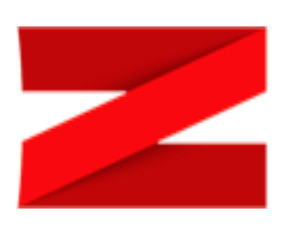

In [620]:
from IPython import display
display.Image('/Users/monicaxu/Zuckflix/logo.png')

<h3> Importing Libraries & Files 

In [281]:
data = pd.read_csv('/Users/monicaxu/Zuckflix/netflix_titles.csv', index_col='show_id')
data.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [625]:
# add index column
data = pd.DataFrame(data)
data['index'] = range(1,len(data)+1)
data = data.set_index('index')
data.reset_index(inplace=True)
data.head()

,index,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,1,TV Show,3%,,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [290]:
print(data.columns)

Index(['index', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


In [291]:
data_ratings = pd.read_csv('/Users/monicaxu/Zuckflix/titles_and_ratings.csv', index_col=0)
data_ratings.head()

,imdb_rating
title,
Money Heist: The Phenomenon,7.5/10
Money Talks,6.2/10
The Money Trap,6.3/10
All the Boys Love Mandy Lane,5.5/10
Monkey Planet,8.5/10


In [680]:
#drop 4404 since its a percentage - ValueError: Unable to parse string "95%" at position 4404
merged = data.merge(data_ratings, on='title')
merged['imdb_value'] = merged[' imdb_rating'].str[:3]
merged = merged.drop([4404])
merged['imdb_value'] = pd.to_numeric(merged['imdb_value'], downcast='float')
merged = merged.drop_duplicates(subset=['title'])
merged.head()

,index,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,imdb_rating,imdb_value
0,2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,5.9/10,5.9
1,3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6/10,4.6
2,7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",6.0/10,6.0
3,9,Movie,706,Shravan Kumar,"Divya Dutta, Atul Kulkarni, Mohan Agashe, Anup...",India,"April 1, 2019",2019,TV-14,118 min,"Horror Movies, International Movies","When a doctor goes missing, his psychiatrist w...",5.3/10,5.3
4,10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,"December 15, 2017",2008,TV-MA,143 min,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...,6.4/10,6.4


In [655]:
round(merged['imdb_value'].describe(),2)

count    4878.00
mean        6.51
std         1.21
min         1.50
25%         5.80
50%         6.60
75%         7.40
max         9.70
Name: imdb_value, dtype: float64

<h2> 1.2 Data Visualization </h2> 
    <li> Users </li>
    <li> Use Cases  </li>
    <li> Other Criteria </li>

<h2> Users </h2>
<li> The types of users can be segmented into a mature audience, young adults, family friendly</li>
<li> Mature content is the most abundant</li>

Text(0, 0.5, 'Count')

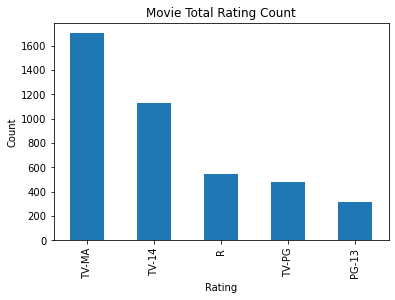

In [656]:
# get types of users 
merged['rating'].value_counts().sort_values(ascending=False)[:5].plot.bar()
plt.title('Movie Total Rating Count')
plt.xlabel('Rating')
plt.ylabel('Count')

<h3> Location </h3>
<li> Majority of content is American produced</li>
<li> International breakthroughs may be possible and gain popularity</li>

Text(0, 0.5, 'Count')

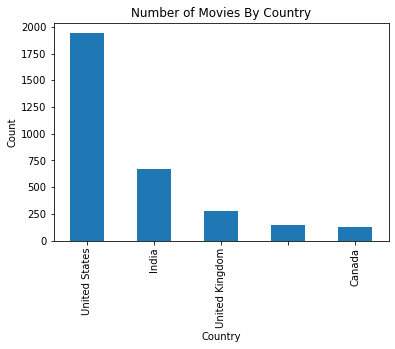

In [657]:
merged['country'].value_counts().sort_values(ascending=False)[:5].plot.bar()
plt.title('Number of Movies By Country')
plt.xlabel('Country')
plt.ylabel('Count')

<h3> Grouped By Country </h3>
<li> Some countries enjoy more mature content than others </li>

Text(0, 0.5, 'Count')

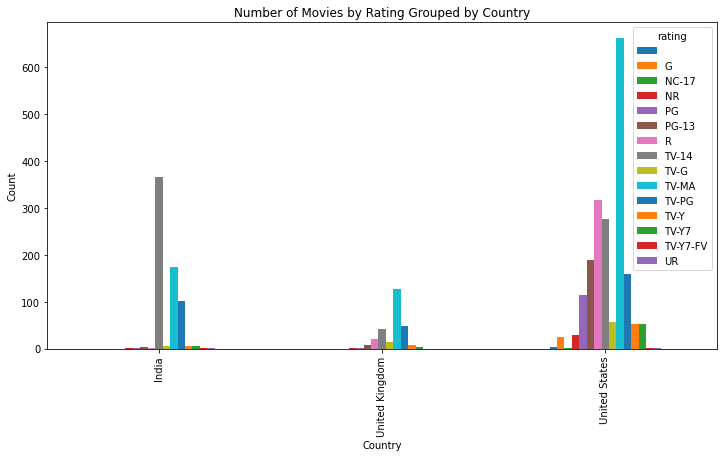

In [658]:
countries = ['United States', 'India', 'United Kingdom']
data_group = merged.loc[merged['country'].isin(countries)]

group_plot = data_group['rating'].groupby(data_group['country']).value_counts()
group_plot.unstack().plot(kind='bar', figsize = (12,6))

plt.title('Number of Movies by Rating Grouped by Country')
plt.xlabel('Country')
plt.ylabel('Count')


<h2> Use Cases </h2>

<h3> Movie/TV Count </h3>

Text(0, 0.5, 'Count')

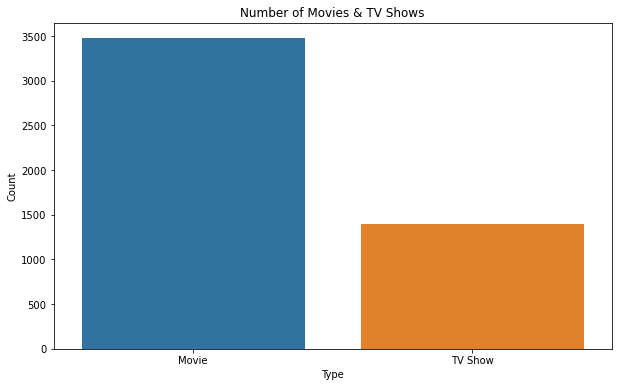

In [659]:
plt.figure(figsize=(10,6))

x= merged.type.value_counts()
sns.countplot(x= "type",data= merged)
plt.title('Number of Movies & TV Shows')
plt.xlabel('Type')
plt.ylabel('Count')

<h3> Grouped By Release Year </h3>
<li> Rise in TV show productions may indicate popularity</li>
<li> Slowed production of movies potentially due to COVID, however TV shows are incresing incrementally </li>

Text(0.5, 1.0, 'Movie and Tv Show Release Years')

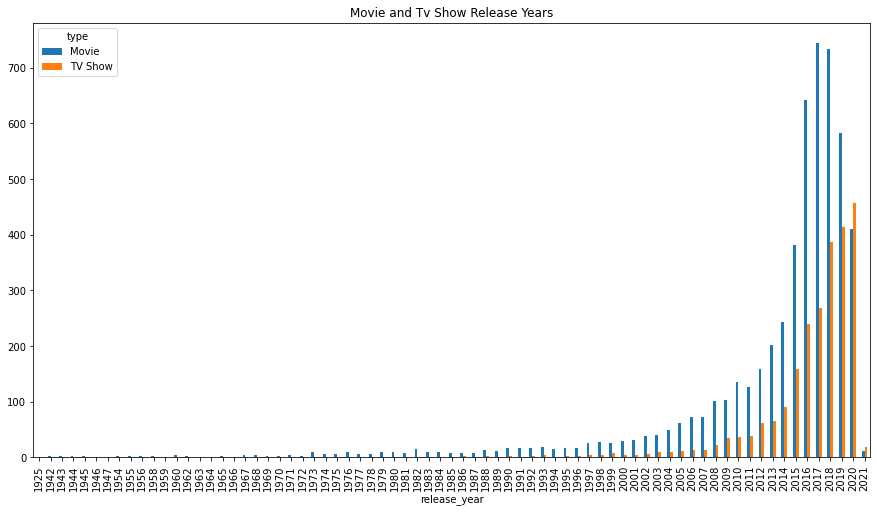

In [660]:
pd.crosstab(data.release_year, data.type).plot(kind='bar',figsize=(15,8))
plt.title('Movie and Tv Show Release Years')

<h2> Other Criteria

<h3> Directors & Series </h3>
<li> Many movies from the same director are often highly rated due to series </li>

<AxesSubplot:xlabel='director'>

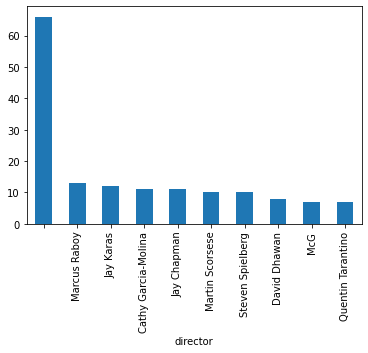

In [682]:
merged.groupby('type').director.value_counts()['Movie'][:10].plot(kind='bar')

In [662]:
director_data = merged[merged['director']=='Steven Spielberg']
dir_sorted = director_data.sort_values('imdb_value', ascending=False)
dir_sorted

,index,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,imdb_rating,imdb_value
3393,5431,Movie,Schindler's List,Steven Spielberg,"Liam Neeson, Ben Kingsley, Ralph Fiennes, Caro...",United States,"April 1, 2018",1993,R,195 min,"Classic Movies, Dramas",Oskar Schindler becomes an unlikely humanitari...,8.9/10,8.9
1911,2993,Movie,Indiana Jones and the Raiders of the Lost Ark,Steven Spielberg,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",United States,"January 1, 2019",1981,PG,116 min,"Action & Adventure, Children & Family Movies, ...",When Indiana Jones is hired by the government ...,8.4/10,8.4
1909,2992,Movie,Indiana Jones and the Last Crusade,Steven Spielberg,"Harrison Ford, Sean Connery, Denholm Elliott, ...",United States,"January 1, 2019",1989,PG-13,127 min,"Action & Adventure, Children & Family Movies, ...","Accompanied by his father, Indiana Jones sets ...",8.2/10,8.2
793,1243,Movie,Catch Me If You Can,Steven Spielberg,"Leonardo DiCaprio, Tom Hanks, Christopher Walk...","United States, Canada","January 1, 2021",2002,PG-13,141 min,Dramas,An FBI agent makes it his mission to put cunni...,8.1/10,8.1
1912,2994,Movie,Indiana Jones and the Temple of Doom,Steven Spielberg,"Harrison Ford, Kate Capshaw, Amrish Puri, Rosh...",United States,"January 1, 2019",1984,PG,119 min,"Action & Adventure, Children & Family Movies, ...","Indiana Jones, his young sidekick and a spoile...",7.5/10,7.5
2328,3647,Movie,Lincoln,Steven Spielberg,"Daniel Day-Lewis, Sally Field, David Strathair...","United States, India","February 21, 2018",2012,PG-13,150 min,Dramas,Director Steven Spielberg takes on the towerin...,7.3/10,7.3
3824,6070,Movie,The Adventures of Tintin,Steven Spielberg,"Jamie Bell, Andy Serkis, Daniel Craig, Nick Fr...","United States, New Zealand, United Kingdom","November 20, 2019",2011,PG,107 min,Children & Family Movies,This 3-D motion capture adapts Georges Remi's ...,7.3/10,7.3
4798,7479,Movie,War Horse,Steven Spielberg,"Emily Watson, David Thewlis, Peter Mullan, Nie...","United States, India","May 6, 2019",2011,PG-13,147 min,Dramas,"During World War I, the bond between a young E...",7.2/10,7.2
1779,2800,Movie,Hook,Steven Spielberg,"Dustin Hoffman, Robin Williams, Julia Roberts,...",United States,"January 15, 2021",1991,PG,142 min,Children & Family Movies,"Peter Pan, now grown up and a workaholic, must...",6.8/10,6.8
1907,2991,Movie,Indiana Jones and the Kingdom of the Crystal S...,Steven Spielberg,"Harrison Ford, Cate Blanchett, Karen Allen, Ra...",United States,"January 1, 2019",2008,PG-13,123 min,"Action & Adventure, Children & Family Movies, ...",Indiana Jones is drawn into a Russian plot to ...,6.1/10,6.1


<h2> Part 2: Movie Recommender

In [666]:
# aggregate important features to train model
features = ['listed_in','cast', 'director', 'rating']
print(features)

['listed_in', 'cast', 'director', 'rating']


In [667]:
# replace null values with null strings 
for feature in features:
    data[feature] = data[feature].fillna('') 

In [668]:
# store all features together for each movie 
combined_features = data['listed_in']+ ' '+ data['cast'] + ' ' + data['director'] +  ' ' + data['rating']

In [669]:
print(combined_features)

0       International TV Shows, TV Dramas, TV Sci-Fi &...
1       Dramas, International Movies Demián Bichir, Hé...
2       Horror Movies, International Movies Tedd Chan,...
3       Action & Adventure, Independent Movies, Sci-Fi...
4       Dramas Jim Sturgess, Kevin Spacey, Kate Boswor...
                              ...                        
7782    Dramas, International Movies Imad Creidi, Anto...
7783    Dramas, International Movies, Music & Musicals...
7784    Documentaries, International Movies, Music & M...
7785    International TV Shows, Reality TV Adriano Zum...
7786      Documentaries, Music & Musicals  Sam Dunn TV-MA
Length: 7787, dtype: object


In [670]:
# convert text to data to feature vector to find cosine similarity
vectorizer = TfidfVectorizer()

In [671]:
# store numerical data 
feature_vectors = vectorizer.fit_transform(combined_features)

In [672]:
print(feature_vectors)

  (0, 16932)	0.050284312658845344
  (0, 9453)	0.2336052933880531
  (0, 5157)	0.2105076429936704
  (0, 19334)	0.2336052933880531
  (0, 31553)	0.22338442026512248
  (0, 17373)	0.2336052933880531
  (0, 25490)	0.16371450134357118
  (0, 9530)	0.2336052933880531
  (0, 18396)	0.17096632623176106
  (0, 22421)	0.20591172225400198
  (0, 30021)	0.2336052933880531
  (0, 16740)	0.1930349449825499
  (0, 22897)	0.1743323555019773
  (0, 20932)	0.2020259266360284
  (0, 29573)	0.2336052933880531
  (0, 29510)	0.2336052933880531
  (0, 23844)	0.2020259266360284
  (0, 10438)	0.21613259537693258
  (0, 18645)	0.1699372945881672
  (0, 6024)	0.21613259537693258
  (0, 3454)	0.1796589875423299
  (0, 18695)	0.15297386187288317
  (0, 13689)	0.1930349449825499
  (0, 8864)	0.10772199748495405
  (0, 9130)	0.10772199748495405
  :	:
  (7783, 12690)	0.05103214334339587
  (7784, 19931)	0.7605396426245983
  (7784, 19569)	0.35923669793582186
  (7784, 19568)	0.35923669793582186
  (7784, 7478)	0.28253871860786295
  (7784, 193

In [673]:
# find similarity score (confidence value
similarity = cosine_similarity(feature_vectors)

In [674]:
print(similarity)

[[1.         0.08585599 0.00246259 ... 0.0278352  0.03989828 0.02228953]
 [0.08585599 1.         0.00871191 ... 0.03078398 0.01372766 0.01551823]
 [0.00246259 0.00871191 1.         ... 0.02367286 0.00570631 0.        ]
 ...
 [0.0278352  0.03078398 0.02367286 ... 1.         0.03730218 0.39876057]
 [0.03989828 0.01372766 0.00570631 ... 0.03730218 1.         0.02294975]
 [0.02228953 0.01551823 0.         ... 0.39876057 0.02294975 1.        ]]


In [675]:
# each movie will be compared to the other movies
print(similarity.shape)

(7787, 7787)


In [683]:
# get movie name 
movie_name = input('Enter favourite movie: ')

Enter favourite movie: The Bachelor


In [684]:
# array to store all movie names 
title_array = data['title'].tolist()

In [685]:
# looping for close similarity score 
matched_movies = difflib.get_close_matches(movie_name, title_array)
print(matched_movies)

['The Bachelor', 'The Bachelors', 'The Bachelorette']


In [686]:
close_match = matched_movies[0]
print(close_match)

The Bachelor


In [687]:
# find index of the movie 
index_movie = data[data.title == close_match]['index'].values[0]
print(index_movie)

6105


In [688]:
# find similarity score 
similarity_score = list(enumerate(similarity[index_movie]))# score compared to iron man
print(similarity_score)

[(0, 0.08057935799085361), (1, 0.01825474818422465), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.07759607368742062), (6, 0.015920232726299756), (7, 0.0), (8, 0.037662442083879144), (9, 0.016371979465790033), (10, 0.020338688354195732), (11, 0.09540960993696052), (12, 0.22444661398503155), (13, 0.029314743628893056), (14, 0.0), (15, 0.028458411447429034), (16, 0.0794791947697058), (17, 0.0), (18, 0.03704375281137493), (19, 0.03420718581763911), (20, 0.03807770053978603), (21, 0.03967221482640071), (22, 0.03563444128152867), (23, 0.042976584969404034), (24, 0.07588985955801597), (25, 0.0), (26, 0.7094655747064957), (27, 0.02989075901459785), (28, 0.05755108297668789), (29, 0.03822402775375809), (30, 0.13012366810927178), (31, 0.052318160651691155), (32, 0.053613577558411396), (33, 0.03614662352427585), (34, 0.08990016466114001), (35, 0.04503391133796993), (36, 0.016336175513510198), (37, 0.014836687586800169), (38, 0.243031129313978), (39, 0.014895133382699412), (40, 0.029689920629886457), (41, 

In [689]:
# sort movies based on similarity score, desc 
sorted_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True)
print(sorted_movies)

[(2989, 1.0), (6104, 1.0), (6105, 1.0), (1625, 0.9125797306935708), (680, 0.8759929800243363), (994, 0.8757475611618117), (6202, 0.8757475611618117), (428, 0.824380976810223), (1695, 0.824380976810223), (4787, 0.8158855197359216), (702, 0.8008738159427866), (1047, 0.7825545675782057), (2087, 0.780940526118618), (6224, 0.780940526118618), (7164, 0.780940526118618), (2441, 0.7621984212556038), (7065, 0.7621984212556038), (7630, 0.7621984212556038), (1864, 0.7608397464560049), (5911, 0.7608397464560049), (2168, 0.7199283638841414), (4024, 0.7199283638841414), (26, 0.7094655747064957), (130, 0.7094655747064957), (980, 0.7094655747064957), (1880, 0.7094655747064957), (2121, 0.7094655747064957), (3021, 0.7094655747064957), (3113, 0.7094655747064957), (4103, 0.7094655747064957), (4704, 0.7094655747064957), (5489, 0.7094655747064957), (5584, 0.7094655747064957), (5646, 0.7094655747064957), (7154, 0.7094655747064957), (7539, 0.7094655747064957), (1386, 0.6918026416675376), (2846, 0.691802641667

In [690]:
# print similar movie names 
print("Movies Recommended For You Similar to " + matched_movies[0] + ":")
i =1 
for movie in sorted_movies:
    index = movie[0]
    title = data[data.index == index]['title'].values[0]
    if i < 15:
        print(i, '-', title)
        i+=1

Movies Recommended For You Similar to The Bachelor:
1 - Indian Matchmaking
2 - The Bachelor
3 - The Bachelorette
4 - Dating Around
5 - Back with the Ex
6 - Blown Away
7 - The Casketeers
8 - Alone
9 - DeMarcus Family Rules
10 - Passion. Panache. Pep
11 - Baewatch: Parental Guidance
12 - Border Security: America's Front Line
13 - Fabulous Lives of Bollywood Wives
14 - The Circle France


In [691]:
movie_name = input('Enter favourite movie: ')

title_array = data['title'].tolist()

matched_movies = difflib.get_close_matches(movie_name, title_array)

close_match = matched_movies[0]

index_movie = data[data.title == close_match]['index'].values[0]

similarity_score = list(enumerate(similarity[index_movie]))

sorted_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True)

print("Movies Recommended For You Similar to " + matched_movies[0] + ":")
i =1 
for movie in sorted_movies:
    index = movie[0]
    title = data[data.index == index]['title'].values[0]
    if i < 15:
        print(i, '-', title)
        i+=1

Enter favourite movie: Bachelor
Movies Recommended For You Similar to The Bachelor:
1 - Indian Matchmaking
2 - The Bachelor
3 - The Bachelorette
4 - Dating Around
5 - Back with the Ex
6 - Blown Away
7 - The Casketeers
8 - Alone
9 - DeMarcus Family Rules
10 - Passion. Panache. Pep
11 - Baewatch: Parental Guidance
12 - Border Security: America's Front Line
13 - Fabulous Lives of Bollywood Wives
14 - The Circle France
